In [133]:
"""
Setting for google colab
"""
# The path of your project on google drive
path_project = "/content/drive/MyDrive/cartography msc/Thesis TUM 2024/"

# Connect colab with google drive
from google.colab import drive
drive.mount('/content/drive')

# Set the project path as current working directory
import os
os.chdir(path_project)
print("Current files under the working directory:", os.listdir())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current files under the working directory: ['momepy', 'NetworkX', 'Ground_truth.ipynb', 'Asia_Korail_Morphometrics_training+testing.ipynb', 'Asia_Korail_topology_training+testing.ipynb', 'buildings.gsheet', 'gdf_nodes.gsheet', 'All in one notebook.ipynb', 'buildings.csv', 'centroids_gdf.csv', 'joined_gdf.csv', 'shapefiles slums', 'cache', 'All in one notebook_tra&test.ipynb', ' Paraguay_All in one notebook_tra&test.ipynb', 'more features_machine learning_kmeans_All in one notebook_Korail.ipynb', 'merged_df.csv', 'joined.csv', ' Training_Stepwise searching_3metrics_Korail_Bangladesh.ipynb', 'Testing2_RicardoBrugada_Paraguay_RF.ipynb', 'Testing1_Katanga_Uganda_RF.ipynb', 'rf_model_korail.pkl', 'MACHINE LEARNING', 'writing', 'rf_model_korail_morpho.pkl', 'rf_model_korail_topo.pkl']


# Imports

In [134]:
!pip install momepy
!pip install osmnx
!pip install PyDrive
!pip install clustergram
!pip install folium matplotlib mapclassify
!pip install shapely
!pip install matplotlib-scalebar
!pip install basemap

import pandas as pd
import geopandas as gpd
import networkx as nx
import numpy as np
import momepy as mm
import pyproj
import osmnx as ox
import libpysal
from shapely.geometry import box
from time import time
from clustergram import Clustergram
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from bokeh.io import output_notebook
from bokeh.plotting import show
from scipy.spatial.distance import euclidean
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.basemap import Basemap

from shapely import LineString
from shapely.geometry import Point

# Usage of osmnx to get the data

In [135]:
point = (0.335044, 32.575066)
dist = 700
gdf = ox.geometries.geometries_from_point(point, dist=dist, tags={'building':True})
gdf2 = ox.geometries.geometries_from_point(point, dist=dist, tags={'residential':['irregular_settlement']})
gdf_projected = ox.projection.project_gdf(gdf)
gdf_projected_2 = ox.projection.project_gdf(gdf2)
buildings = gdf_projected[gdf_projected.geom_type.isin(['Polygon', 'MultiPolygon'])]
Katanga = gdf_projected_2[gdf_projected_2.geom_type.isin(['Polygon', 'MultiPolygon'])]

buildings['uID'] = mm.unique_id(buildings)
Katanga['uID'] = mm.unique_id(Katanga)
limit = mm.buffered_limit(buildings) # this define limit for momepy.Tessellation as a buffer around buildings.
tessellation = mm.Tessellation(buildings, unique_id='uID', limit=limit).tessellation

# Ensure that Korail is a single polygon (dissolve if there are multiple polygons)
Katanga_union = Katanga.unary_union

<ipython-input-135-5d734f887dc0>:3: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf = ox.geometries.geometries_from_point(point, dist=dist, tags={'building':True})
<ipython-input-135-5d734f887dc0>:4: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf2 = ox.geometries.geometries_from_point(point, dist=dist, tags={'residential':['irregular_settlement']})
<ipython-input-135-5d734f887dc0>:13: Futur

Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


<ipython-input-135-5d734f887dc0>:13: UserWarning: Tessellation contains MultiPolygon elements. Initial objects should  be edited. `unique_id` of affected elements: [1828, 2220, 558, 2380, 1737, 1765, 793, 1030].
  tessellation = mm.Tessellation(buildings, unique_id='uID', limit=limit).tessellation


In [136]:
#Number of buildings obtained for training dataset
total_buildings = len(buildings)
print(f"Total number of buildings: {total_buildings}")

Total number of buildings: 2632


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


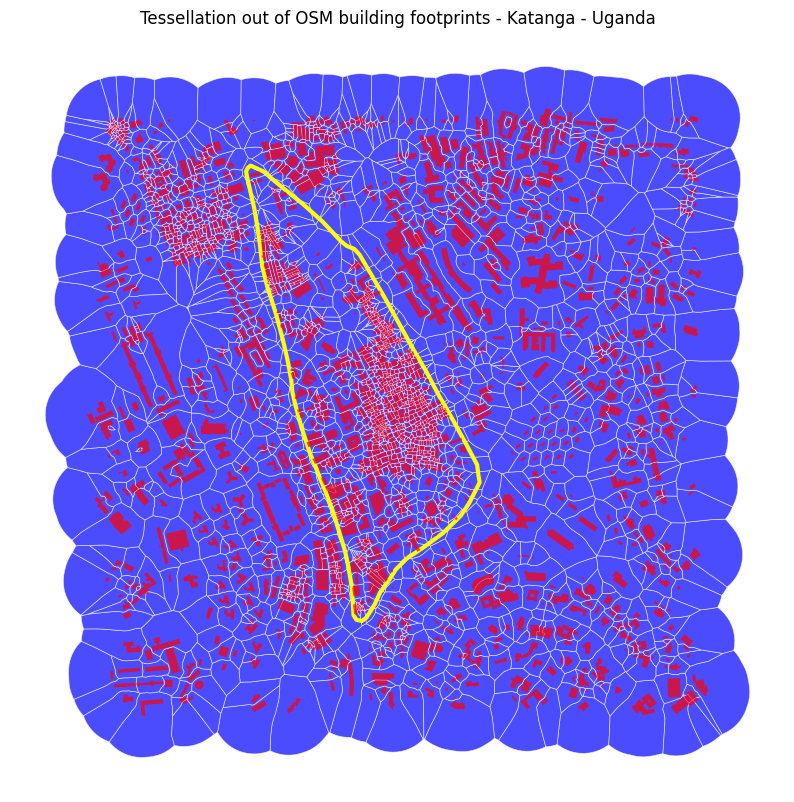

In [137]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, edgecolor='white', legend=True, linewidth=0.5, facecolor='blue', alpha=.7)
Katanga.plot(ax=ax, edgecolor='yellow', legend=True, facecolor='none', linewidth=3)
buildings.plot(ax=ax, color='red', legend=True, alpha=.7)
plt.title('Tessellation out of OSM building footprints - Katanga - Uganda')
ax.set_axis_off()
plt.show()

## Areas
Building areas

In [138]:
blg_area = mm.Area(buildings)
buildings['area'] = blg_area.series

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-138-0e5a57a77097>:1: FutureWarning: `momepy.Area` is deprecated. Replace it with `.area` attribute of a GeoDataFrame or pin momepy version <1.0. This class will be removed in 1.0. 
  blg_area = mm.Area(buildings)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


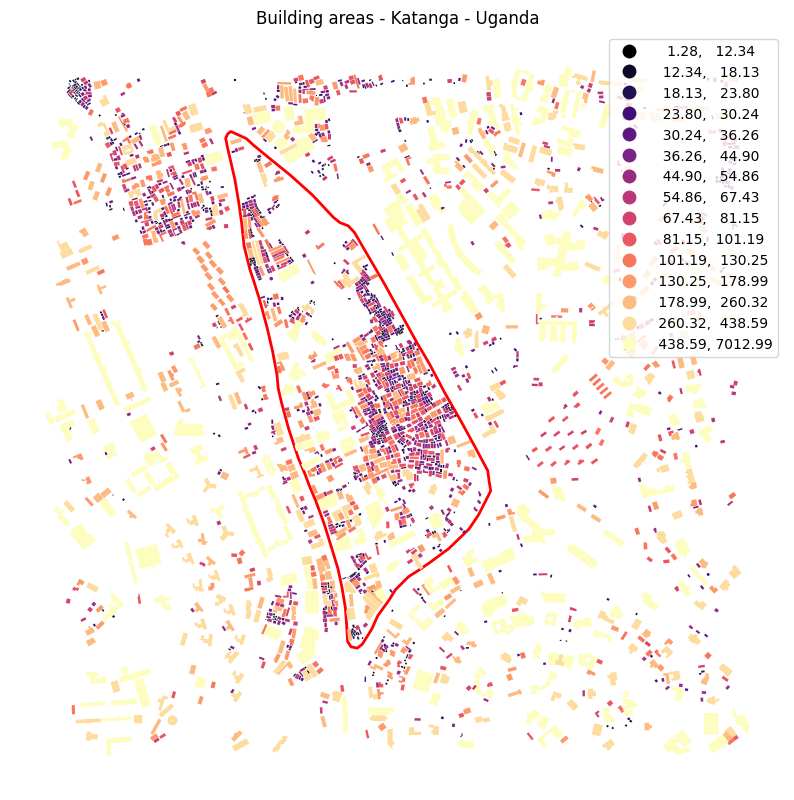

In [139]:
f, ax = plt.subplots(figsize=(10, 10))
Katanga.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2)
buildings.plot(ax=ax, column='area', legend=True, scheme='quantiles', k=15, cmap='magma')
plt.title('Building areas - Katanga - Uganda')
ax.set_axis_off()
plt.show()

## **SPATIAL DISTRIBUTION METRICS**

# Distance to neighbours buidlings

Caculates the distance to neighbours buildings through queen contiguity weights of the first order capturing the relationship between immediate neighbours.Relationship between buildings is here represented by relationships between their tessellation cells.

In [140]:
sw1 = mm.sw_high(k=1, gdf=tessellation, ids='uID')
buildings['neighbour_dist'] = mm.NeighborDistance(buildings, sw1, 'uID').series
buildings = buildings.dropna(subset=['neighbour_dist'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-140-e5654393bf88>:1: FutureWarning: `momepy.sw_high` is deprecated. Replace it with .higher_order() method of libpysal.graph.Graph or pin momepy version <1.0. This class will be removed in 1.0. 
  sw1 = mm.sw_high(k=1, gdf=tessellation, ids='uID')
<ipython-input-140-e5654393bf88>:2: FutureWarning: Class based API like `momepy.NeighborDistance` is deprecated. Replace it with `momepy.neighbor_distance` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings['neighbour_dist'] = mm.NeighborDistance(buildings, sw1, 'uID').series


  0%|          | 0/2632 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


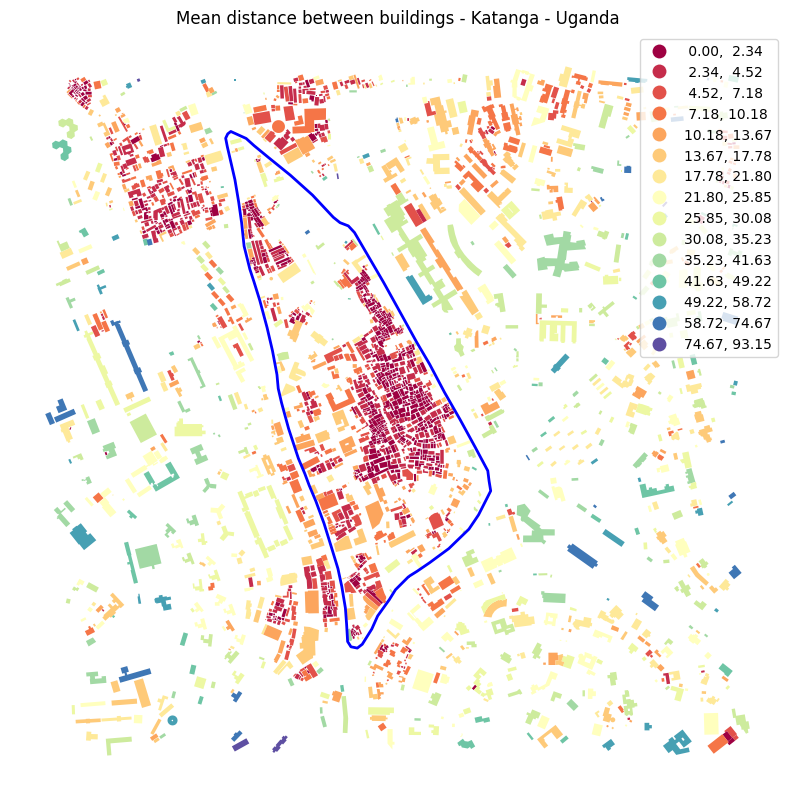

In [141]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax, column='neighbour_dist', scheme='naturalbreaks', k=15, legend=True, cmap='Spectral')
Katanga.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=2)
plt.title('Mean distance between buildings - Katanga - Uganda')
ax.set_axis_off()
plt.show()

# Mean Interbuilding Distance

 Interbuilding distances are calculated between buildings on adjacent cells based on spatial_weights,

In [142]:
MID = mm.MeanInterbuildingDistance(buildings, sw1,'uID')
buildings['mean_interbuilding_distance'] = MID.series


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-142-d2f1a476d11a>:1: FutureWarning: Class based API like `momepy.MeanInterbuildingDistance` is deprecated. Replace it with `momepy.mean_interbuilding_distance` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  MID = mm.MeanInterbuildingDistance(buildings, sw1,'uID')


Computing mean interbuilding distances...


  0%|          | 0/2632 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


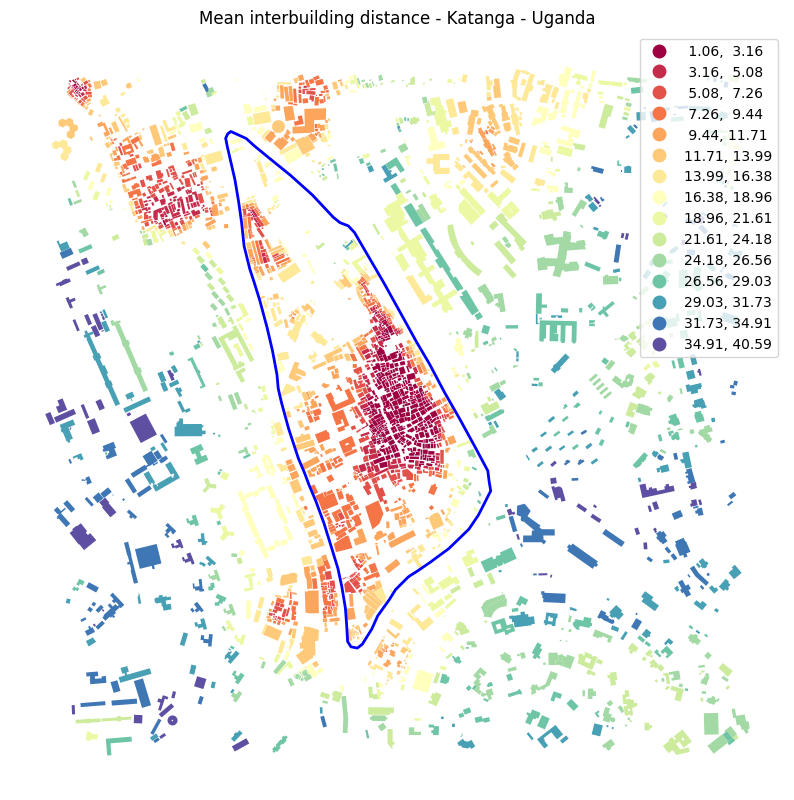

In [143]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax, column='mean_interbuilding_distance', scheme='naturalbreaks', k=15, legend=True, cmap='Spectral')
Katanga.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=2)
plt.title('Mean interbuilding distance - Katanga - Uganda')
ax.set_axis_off()
plt.show()

In [144]:
print(buildings.columns)

Index(['geometry', 'name', 'nodes', 'building', 'source', 'wikidata', 'ref',
       'department', 'building:levels', 'operator', 'residential', 'shop',
       'amenity', 'religion', 'addr:city', 'addr:country', 'addr:housenumber',
       'addr:street', 'office', 'opening_hours', 'government', 'healthcare',
       'smoking', 'multipurpose', 'fixme', 'height', 'nohousenumber', 'layer',
       'roof:colour', 'wheelchair', 'building:material', 'roof:shape',
       'historic', 'ways', 'type', 'addr:postcode', 'addr:unit', 'email',
       'description', 'note', 'uID', 'area', 'neighbour_dist',
       'mean_interbuilding_distance'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [145]:
# features = buildings[['area', 'neighbour_dist', 'mean_interbuilding_distance']]
# print(buildings.head())

# TOPOLOGY METRICS

# Obtain basic dataset = Centroids of the buildings

In [146]:
# Centroids of the buildings
def multipolygon_centroid(geom):
    if geom.geom_type == 'MultiPolygon':
        return geom.convex_hull.centroid
    else:
        return geom.centroid

buildings['centroid'] = buildings.geometry.apply(multipolygon_centroid)

# Create a GeoDataFrame for the centroids with uID
centroids_gdf = gpd.GeoDataFrame({
    'uID': buildings['uID'],
    'geometry': buildings['centroid']
}, crs=buildings.crs)

In [147]:
print(buildings.columns)

Index(['geometry', 'name', 'nodes', 'building', 'source', 'wikidata', 'ref',
       'department', 'building:levels', 'operator', 'residential', 'shop',
       'amenity', 'religion', 'addr:city', 'addr:country', 'addr:housenumber',
       'addr:street', 'office', 'opening_hours', 'government', 'healthcare',
       'smoking', 'multipurpose', 'fixme', 'height', 'nohousenumber', 'layer',
       'roof:colour', 'wheelchair', 'building:material', 'roof:shape',
       'historic', 'ways', 'type', 'addr:postcode', 'addr:unit', 'email',
       'description', 'note', 'uID', 'area', 'neighbour_dist',
       'mean_interbuilding_distance', 'centroid'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


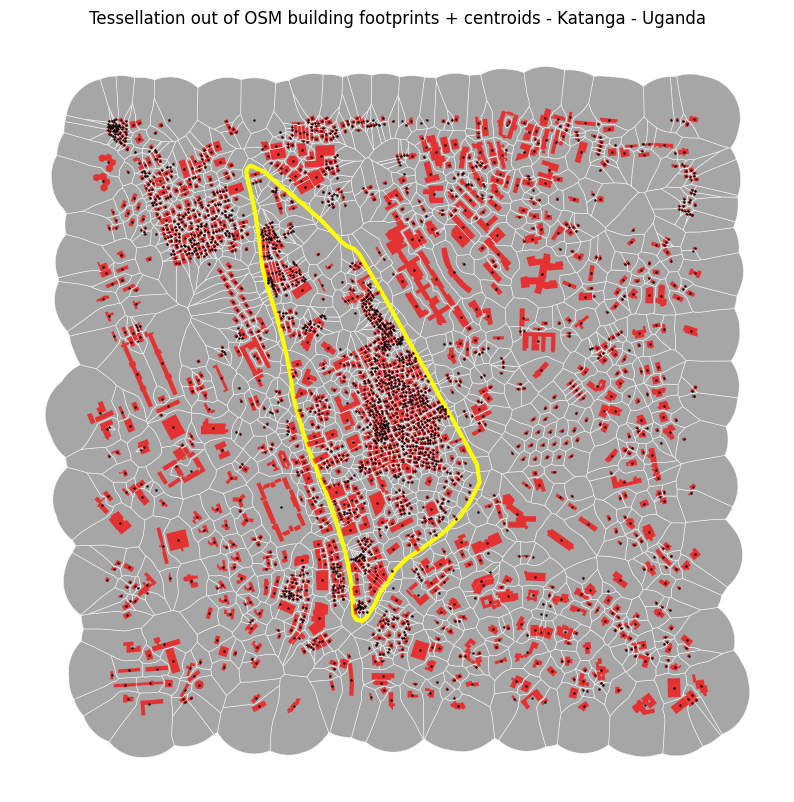

In [148]:
# Plot
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, edgecolor='white', linewidth=0.5, facecolor='grey', alpha=.7)
Katanga.plot(ax=ax, edgecolor='yellow', facecolor='none', linewidth=3)
buildings.plot(ax=ax, color='red', alpha=.7)
centroids_gdf.plot(ax=ax, color='black', markersize=0.5, marker='o', label='Centroids')
plt.title('Tessellation out of OSM building footprints + centroids - Katanga - Uganda')
ax.set_axis_off()
plt.show()

In [149]:
total_nodes = len(centroids_gdf)
print(f"Total number of nodes: {total_nodes}")
total_buildings = len(buildings)
print(f"Total number of buildings: {total_buildings}")

Total number of nodes: 2632
Total number of buildings: 2632


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Delaunay Triangulation

In [150]:
#Coordinates based on the centroids of the buildings
coordinates = np.column_stack((centroids_gdf.geometry.x, centroids_gdf.geometry.y))

from scipy.spatial import Delaunay
tri = Delaunay(coordinates)

# Create a networkx graph out of the Delaunay triangulation
G = nx.Graph()

# Add edges to the graph
for simplex in tri.simplices:
    for i in range(3):
        for j in range(i + 1, 3):
            G.add_edge(simplex[i], simplex[j])

# Get positions of the nodes for plotting
positions = {i: (coordinates[i, 0], coordinates[i, 1]) for i in range(len(coordinates))}

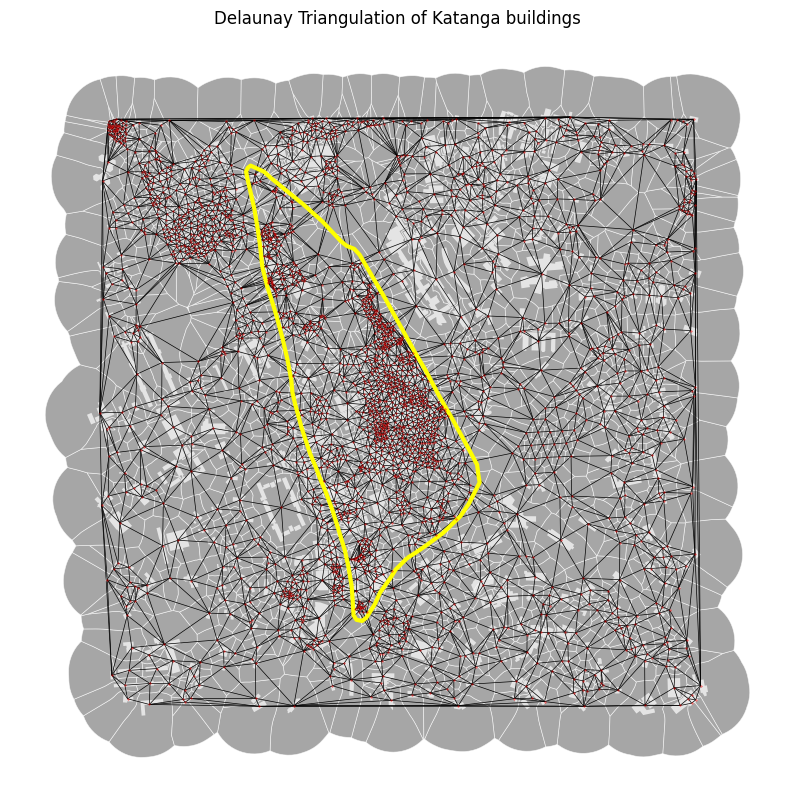

In [151]:
# Plot
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, edgecolor='white', linewidth=0.5, facecolor='grey', alpha=.7)
buildings.plot(ax=ax, color='white', alpha=.7)

# Edges of the Delaunay triangulation
nx.draw(G, pos=positions, node_size=0.1, node_color='red', edge_color='black', width=0.5)
Katanga.plot(ax=ax, edgecolor='yellow', facecolor='none', linewidth=3)
plt.title('Delaunay Triangulation of Katanga buildings')
plt.show()

# Weighted distance

In [152]:
# Edges to the graph with weights based on Euclidean distance
for simplex in tri.simplices:
    for i in range(3):
        for j in range(i + 1, 3):
            p1 = coordinates[simplex[i]]
            p2 = coordinates[simplex[j]]
            distance = euclidean(p1, p2) #scipy
            G.add_edge(simplex[i], simplex[j], weight=distance) #networkx

# Extract edges with their weights
edges = []
for u, v, data in G.edges(data=True):
    line = LineString([coordinates[u], coordinates[v]])
    edges.append({'geometry': line, 'weight': data['weight']})

# Geodataframe of edges
gdf_edges = gpd.GeoDataFrame(edges)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


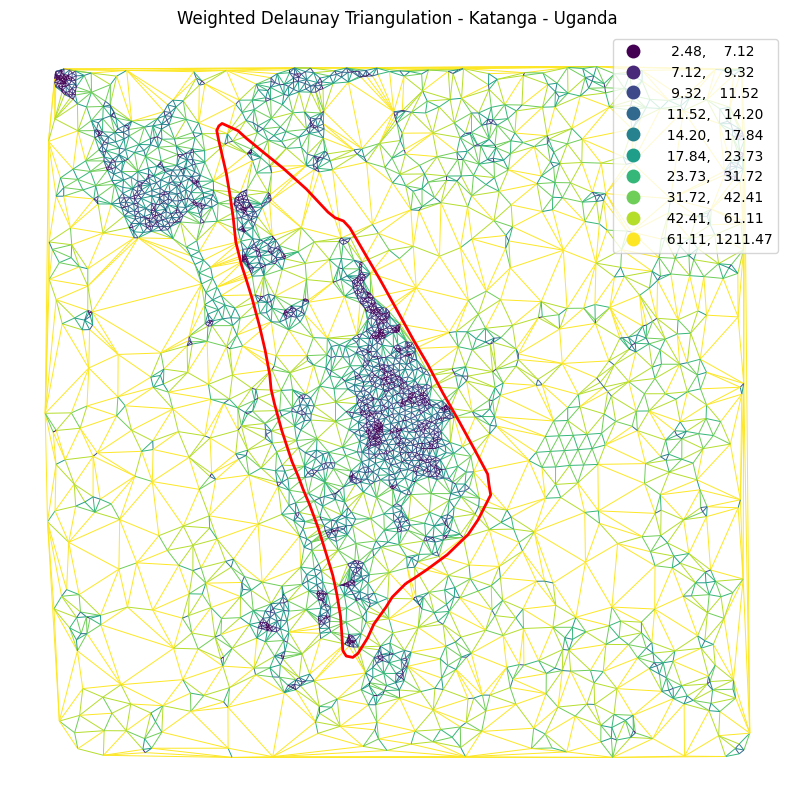

In [153]:
#Plot
f, ax = plt.subplots(figsize=(10, 10))
Katanga.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2, zorder=10)

# centroids_gdf.plot(ax=ax, color='grey', markersize=0.5, marker='o', label='Centroids', zorder=5)

gdf_edges.plot(ax=ax, column='weight', legend=True, scheme='quantiles', k=10, cmap='viridis', linewidth=0.7, zorder=0)

plt.title('Weighted Delaunay Triangulation - Katanga - Uganda')
ax.set_axis_off()
plt.show()

In [154]:
# Initialize a dictionary to store average weighted distances for each node
node_avg_weighted_distance = {}

# Loop through each node in the graph
for node in G.nodes():
    # Get all neighboring nodes (adjacent nodes)
    neighbors = list(G.neighbors(node))

    # Calculate average weighted distance
    total_weighted_distance = 0.0
    count = 0

    # Iterate over edges connecting the node to its neighbors
    for neighbor in neighbors:
        # Get the weight of the edge between node and neighbor
        weight = G[node][neighbor]['weight']

        # Accumulate weighted distance
        total_weighted_distance += weight
        count += 1

    # Calculate average weighted distance for the node
    if count > 0:
        avg_weighted_distance = total_weighted_distance / count
    else:
        avg_weighted_distance = 0.0

    # Store the average weighted distance in the dictionary
    node_avg_weighted_distance[node] = avg_weighted_distance

# Print or use node_avg_weighted_distance as needed
print(node_avg_weighted_distance)

{1049: 247.08512131080934, 100: 164.24649285982704, 511: 293.0213789091556, 2562: 20.55680171877038, 2566: 22.388764437045673, 2564: 18.038861820574414, 534: 105.94373789880252, 3: 163.93705410488127, 165: 145.23723399213773, 318: 81.16920607486112, 2557: 124.93533758389215, 2: 60.48182099445258, 2623: 90.2793079646794, 423: 280.3379893670697, 0: 180.99517194286074, 97: 194.3572882811439, 352: 67.17286701516086, 510: 46.16562054905774, 1032: 99.0610944314475, 447: 98.69718372479912, 1675: 288.5229722017311, 1025: 75.50221289265616, 1725: 49.630388817619874, 1728: 87.01068793538154, 1048: 50.01019141701004, 450: 54.156097021726666, 448: 47.989454939329924, 1325: 38.876490775371224, 351: 77.54383451952108, 173: 65.40029577271942, 1039: 104.63830390599814, 341: 64.96122229898826, 1040: 64.19628028133917, 683: 57.922281089006376, 1564: 58.211720496243046, 2536: 56.009901991689105, 139: 70.3471666245518, 1585: 66.55971953638961, 2618: 75.30625707672733, 135: 77.00412457322868, 2612: 199.077

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   avg_weighted_distance
0             180.995172
1              49.731468
2              60.481821
3             163.937054
4              88.903337


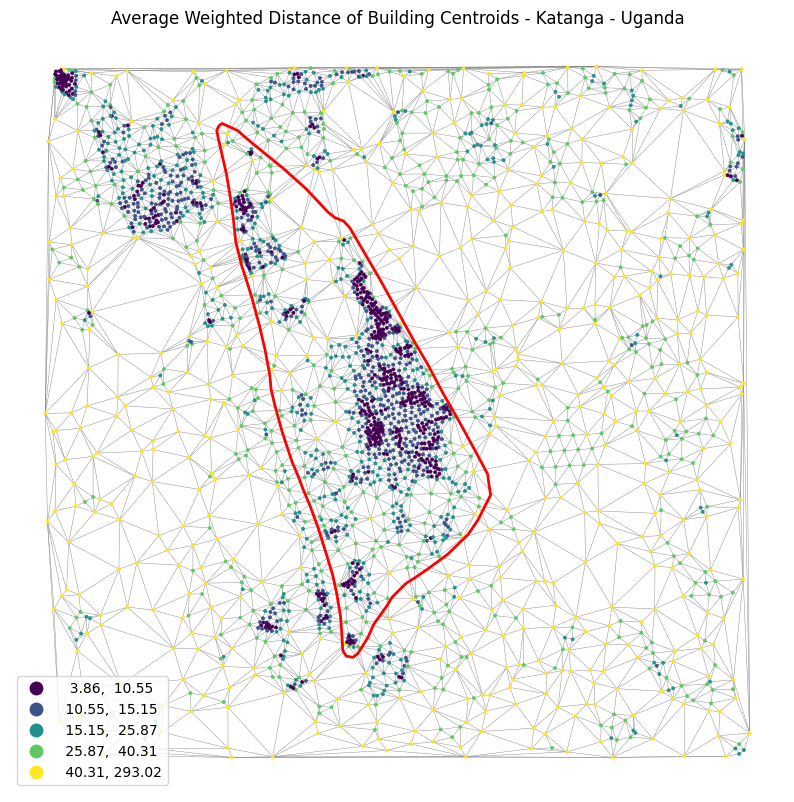

In [155]:
# Ensure that the GeoDataFrame indices match the graph nodes
centroids_gdf = centroids_gdf.reset_index(drop=True)


# Map the average weighted distances to the GeoDataFrame
centroids_gdf['avg_weighted_distance'] = centroids_gdf.index.map(node_avg_weighted_distance)

# Verify the mapping
print(centroids_gdf[['avg_weighted_distance']].head())

# Plot to visualize the average weighted distances
f, ax = plt.subplots(figsize=(10, 10))

# Ensure avg_weighted_distance column exists and is not empty
if 'avg_weighted_distance' in centroids_gdf.columns and not centroids_gdf['avg_weighted_distance'].isnull().all():
    Katanga.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2, zorder=10)
    centroids_gdf.plot(ax=ax, column='avg_weighted_distance',  legend=True, scheme='quantiles', cmap='viridis', markersize=5, linewidth=0.5, zorder=5)
    gdf_edges.plot(ax=ax, color='grey', linewidth=0.3, zorder=0)
    plt.title('Average Weighted Distance of Building Centroids - Katanga - Uganda')
    ax.set_axis_off()
    plt.show()
else:
    print("Average weighted distance data is missing or empty.")

In [156]:
total_nodes = len(centroids_gdf)
print(f"Total number of nodes: {total_nodes}")
#same amount of nodes to buildings :)

Total number of nodes: 2632


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [157]:
print(buildings.columns)

Index(['geometry', 'name', 'nodes', 'building', 'source', 'wikidata', 'ref',
       'department', 'building:levels', 'operator', 'residential', 'shop',
       'amenity', 'religion', 'addr:city', 'addr:country', 'addr:housenumber',
       'addr:street', 'office', 'opening_hours', 'government', 'healthcare',
       'smoking', 'multipurpose', 'fixme', 'height', 'nohousenumber', 'layer',
       'roof:colour', 'wheelchair', 'building:material', 'roof:shape',
       'historic', 'ways', 'type', 'addr:postcode', 'addr:unit', 'email',
       'description', 'note', 'uID', 'area', 'neighbour_dist',
       'mean_interbuilding_distance', 'centroid'],
      dtype='object')


# Spatial Joint MM and TP

In [158]:
# Spatial join using geopandas.sjoin
# Merge buildings and centroids_gdf, ensuring we retain the geometry column
joined_gdf = gpd.GeoDataFrame(
    buildings.merge(centroids_gdf, on='uID', suffixes=('_building', '_centroid')),
    geometry='geometry_building',  # Assuming 'geometry_building' is the name of the geometry column after merging
    crs=buildings.crs  # Ensure the coordinate reference system is retained
)

# Check the first few rows to verify the join


print(joined_gdf.head())
print(joined_gdf.geom_type)

                                   geometry_building  \
0  POLYGON ((453145.714 36322.436, 453142.721 363...   
1  POLYGON ((453329.918 37293.063, 453324.766 372...   
2  POLYGON ((452002.095 36836.342, 452010.241 368...   
3  POLYGON ((451997.220 36816.060, 452016.771 367...   
4  POLYGON ((452130.215 36753.647, 452138.872 367...   

                                                name  \
0                                                NaN   
1                                     Arcadia Suites   
2                         College of Social Sciences   
3                                    Social Sciences   
4  Lincon House Department of Journalism & Commun...   

                                               nodes building source  \
0  [1611890188, 1611890208, 1611890173, 161189019...      yes   Bing   
1  [1700850691, 1700850712, 1700850717, 170085069...      yes    NaN   
2  [1795649611, 1795649612, 1795649603, 179564959...      yes    NaN   
3  [1795649598, 1795649587, 1795649586

GROUND TRUTH DATA

Objective =  classification of OSM building data into slum / non slum buildings using the Katanga neighbourhood polygon as a filter

In [159]:
# Classify buildings as 'slum' if they are within the Korail polygon, else 'non-slum'
buildings['label'] = np.where(buildings.within(Katanga_union), 'slum', 'non-slum')

print("Buildings with labels:")
print(buildings.head())

Buildings with labels:
                                                                 geometry  \
element_type osmid                                                          
way          148077579  POLYGON ((453145.714 36322.436, 453142.721 363...   
             157839880  POLYGON ((453329.918 37293.063, 453324.766 372...   
             168281269  POLYGON ((452002.095 36836.342, 452010.241 368...   
             168281270  POLYGON ((451997.220 36816.060, 452016.771 367...   
             168285344  POLYGON ((452130.215 36753.647, 452138.872 367...   

                                                                     name  \
element_type osmid                                                          
way          148077579                                                NaN   
             157839880                                     Arcadia Suites   
             168281269                         College of Social Sciences   
             168281270                              

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [160]:
ground_truth_gdf = buildings.copy()
ground_truth_gdf['label'] = np.where(buildings.within(Katanga_union), 'slum', 'non-slum')

print("Buildings with labels:")
print(ground_truth_gdf.head())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Buildings with labels:
                                                                 geometry  \
element_type osmid                                                          
way          148077579  POLYGON ((453145.714 36322.436, 453142.721 363...   
             157839880  POLYGON ((453329.918 37293.063, 453324.766 372...   
             168281269  POLYGON ((452002.095 36836.342, 452010.241 368...   
             168281270  POLYGON ((451997.220 36816.060, 452016.771 367...   
             168285344  POLYGON ((452130.215 36753.647, 452138.872 367...   

                                                                     name  \
element_type osmid                                                          
way          148077579                                                NaN   
             157839880                                     Arcadia Suites   
             168281269                         College of Social Sciences   
             168281270                              

<ipython-input-177-fb6065645bf0>:14: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles, labels = leg.legendHandles, [text.get_text() for text in leg.get_texts()]


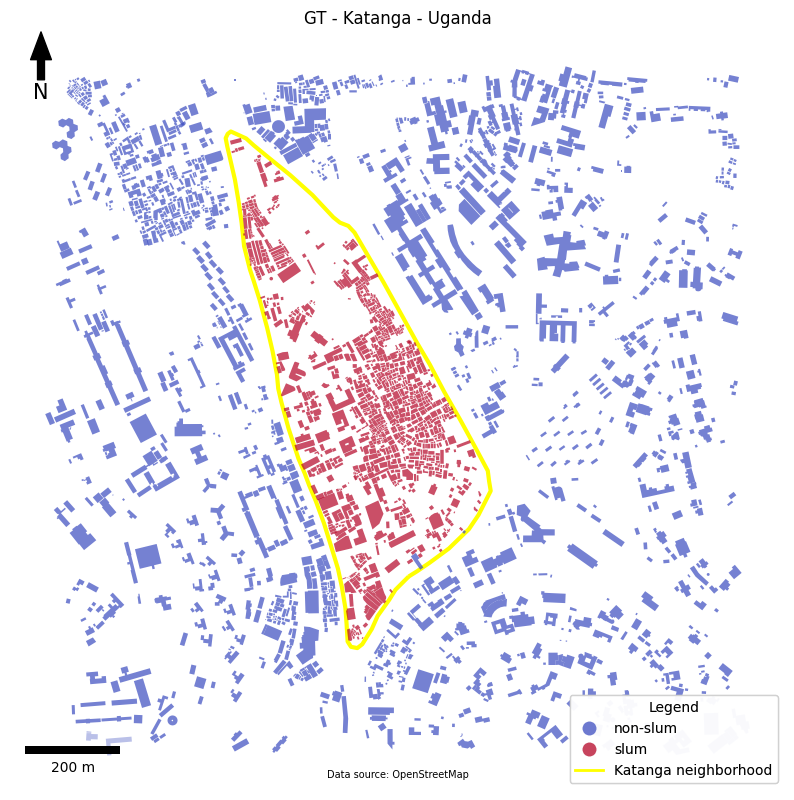

In [177]:

# Plotting the data
f, ax = plt.subplots(figsize=(10, 10))


RB_legend = Line2D([0], [0], color='yellow', lw=2, label='Katanga neighborhood')
Katanga.plot(ax=ax, edgecolor='yellow', facecolor='none', linewidth=3)

ground_truth_gdf.plot(ax=ax, column='label', cmap='coolwarm', alpha=.7, legend=True)

leg = ax.get_legend()

# If the legend is not None, retrieve its handles and labels
if leg:
    handles, labels = leg.legendHandles, [text.get_text() for text in leg.get_texts()]
else:
    handles, labels = [], []
# Append the Korail legend entry
handles.append(RB_legend)
labels.append('Katanga neighborhood')


# Create combined legend
combined_legend = ax.legend(handles=handles, labels=labels, loc='lower right', title='Legend')
ax.add_artist(combined_legend)

# Add scale bar with transparency
scalebar = ScaleBar(1, location='lower left', pad=1, box_alpha=0.5)
ax.add_artist(scalebar)

# Add north arrow with customized design
x, y, arrow_length = 0.04, 1, 0.08
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', headwidth=15, headlength=20, width=5),
            ha='center', va='center', fontsize=15,
            xycoords=ax.transAxes)

# Add resource text
plt.text(0.5, 0.02, 'Data source: OpenStreetMap', horizontalalignment='center',
         verticalalignment='center', transform=ax.transAxes, fontsize=7)

plt.title('GT - Katanga - Uganda')
ax.set_axis_off()
plt.show()


In [162]:
print(ground_truth_gdf['label'].value_counts())

label
non-slum    1541
slum        1091
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Classification method: stepwise searching between defined ranges - Testing in Uganda

In [163]:
#Best Threshold Values from training data (KORAIL)
b_t_area = 61.93477484824078
b_t_per = 352.74298446912377
b_t_mid = 44.35849724422399
b_t_tes_area = 20354.12633413816

# Apply best thresholds to classify buildings
joined_gdf['label'] = np.where(
    (joined_gdf['area'] < b_t_area) &
    (joined_gdf['mean_interbuilding_distance'] < b_t_mid),
    'slum', 'non-slum'
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


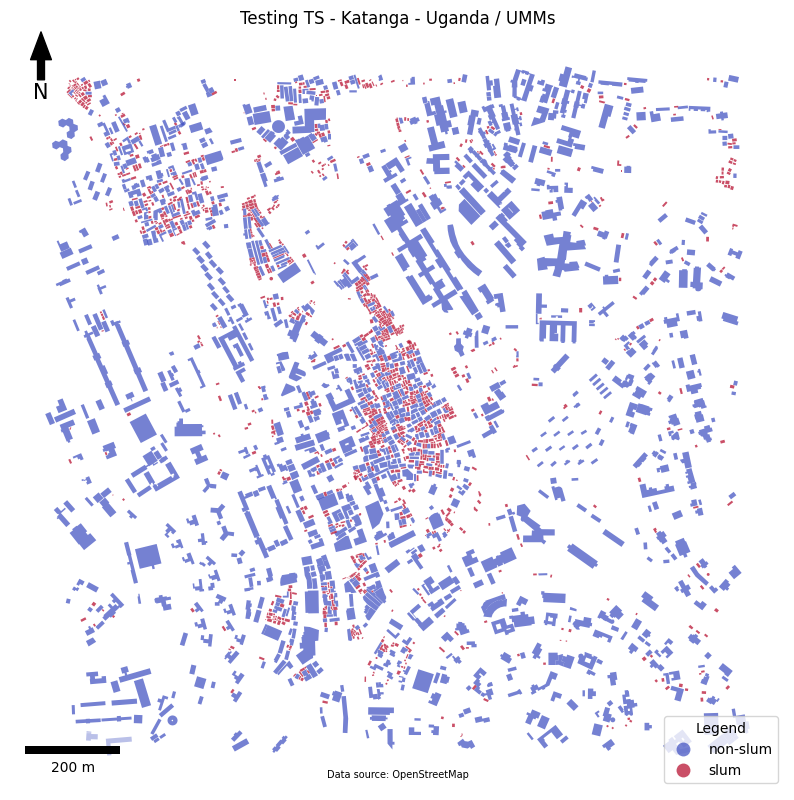

In [164]:
# Plotting the data
f, ax = plt.subplots(figsize=(10, 10))
joined_gdf.plot(column='label', cmap='coolwarm', alpha=.7, legend=True, ax=ax,
                legend_kwds={'loc': 'lower right', 'title': "Legend"})
# Add scale bar with transparency
scalebar = ScaleBar(1, location='lower left', pad=1, box_alpha=0.5)
ax.add_artist(scalebar)

# Add north arrow with customized design
x, y, arrow_length = 0.04, 1, 0.08
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
arrowprops=dict(facecolor='black', headwidth=15, headlength=20, width=5),
            ha='center', va='center', fontsize=15,
            xycoords=ax.transAxes)
# Add resource text
plt.text(0.5, 0.02, 'Data source: OpenStreetMap', horizontalalignment='center',
         verticalalignment='center', transform=ax.transAxes, fontsize=7)

plt.title('Testing TS - Katanga - Uganda / UMMs')
ax.set_axis_off()
plt.show()

In [165]:
print(joined_gdf['label'].value_counts())

label
slum        1340
non-slum    1292
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Testing

In [166]:
# Merge datasets on unique identifier
merged_df = pd.merge(joined_gdf[['uID', 'label']], buildings[['uID', 'label']], on='uID', suffixes=('_pred', '_true'))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [167]:
print(joined_gdf['label'].value_counts())

label
slum        1340
non-slum    1292
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [168]:
# Number of correct predictions
correct_predictions = (merged_df['label_pred'] == merged_df['label_true']).sum()

# Total number of predictions
total_predictions = len(merged_df)

# Overall accuracy
o_accuracy = correct_predictions / total_predictions

print(f"Overall Accuracy: {o_accuracy * 100:.2f}%")

Overall Accuracy: 61.13%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [169]:
# Confusion matrix
conf_matrix = confusion_matrix(merged_df['label_true'], merged_df['label_pred'], labels=['slum', 'non-slum'])



In [170]:
from sklearn.metrics import classification_report

# Classification report
class_report = classification_report(merged_df['label_true'], merged_df['label_pred'], target_names=['slum', 'non-slum'])

print("Classification Report:\n")
print(class_report)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Classification Report:

              precision    recall  f1-score   support

        slum       0.70      0.59      0.64      1541
    non-slum       0.53      0.65      0.58      1091

    accuracy                           0.61      2632
   macro avg       0.61      0.62      0.61      2632
weighted avg       0.63      0.61      0.61      2632



In [171]:
#Best Threshold Values from training data (KORAIL)
b_t_area = 61.93477484824078
b_t_per = 352.74298446912377
b_t_mid = 44.35849724422399
b_t_tes_area = 20354.12633413816
b_t_awd = 46.27806593211198

# Apply best thresholds to classify buildings
joined_gdf['label2'] = np.where(
    (joined_gdf['area'] < b_t_area) &
    (joined_gdf['mean_interbuilding_distance'] < b_t_mid) &
    (joined_gdf['avg_weighted_distance'] < b_t_awd),
    'slum', 'non-slum'
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


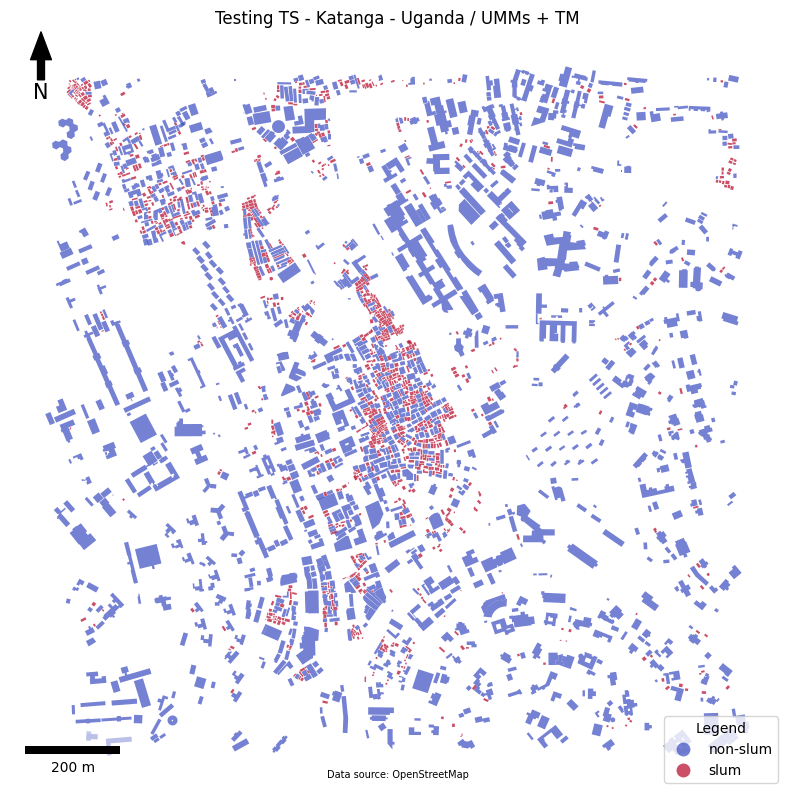

In [172]:
# Plotting the data
f, ax = plt.subplots(figsize=(10, 10))

joined_gdf.plot(column='label2', cmap='coolwarm', alpha=.7, legend=True, ax=ax,
                legend_kwds={'loc': 'lower right', 'title': "Legend"})
# Add scale bar with transparency
scalebar = ScaleBar(1, location='lower left', pad=1, box_alpha=0.5)
ax.add_artist(scalebar)

# Add north arrow with customized design
x, y, arrow_length = 0.04, 1, 0.08
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
arrowprops=dict(facecolor='black', headwidth=15, headlength=20, width=5),
            ha='center', va='center', fontsize=15,
            xycoords=ax.transAxes)
# Add resource text
plt.text(0.5, 0.02, 'Data source: OpenStreetMap', horizontalalignment='center',
         verticalalignment='center', transform=ax.transAxes, fontsize=7)

plt.title('Testing TS - Katanga - Uganda / UMMs + TM')
ax.set_axis_off()
plt.show()


In [173]:
print(joined_gdf['label2'].value_counts())

label2
non-slum    1367
slum        1265
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [174]:
# Merge datasets on unique identifier
merged_df2 = pd.merge(joined_gdf[['uID', 'label2']], buildings[['uID', 'label']], on='uID', suffixes=('_pred', '_true'))
print(merged_df2.columns)

Index(['uID', 'label2', 'label'], dtype='object')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [175]:
# Number of correct predictions
correct_predictions = (merged_df2['label2'] == merged_df2['label']).sum()

# Total number of predictions
total_predictions = len(merged_df2)

# Overall accuracy
o_accuracy = correct_predictions / total_predictions

print(f"Overall Accuracy: {o_accuracy * 100:.2f}%")

Overall Accuracy: 63.53%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
